In [46]:
import matplotlib.pyplot as plt
from face_swap.image_preprocessing import *
from face_swap.utils import *
from face_swap.keypoints import *
import tqdm.notebook as tq

In [47]:
source_img_path = "data/f1.jpg"
target_img_path = "data/macron2.jpg"

source_img = read_image(source_img_path)
target_img = read_image(target_img_path)

s_aligned, s_ldmks = get_aligned_image(source_img)
t_aligned, t_ldmks = get_aligned_image(target_img)

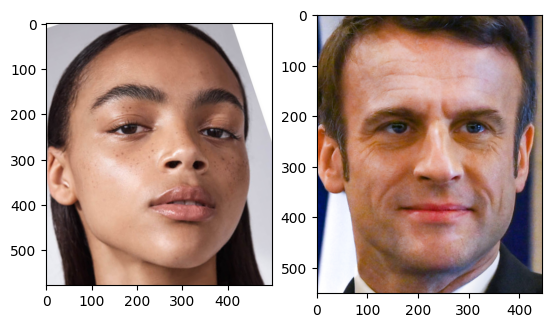

In [48]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

In [61]:

mixed_clone = t_aligned.copy()
added1 = np.zeros(t_aligned.shape, np.uint8)
added2 = np.zeros(t_aligned.shape, np.uint8)
added3 = np.zeros(t_aligned.shape, np.uint8)
k = 0

for i in range(0, int(len(TRIANGULATION) / 3)):
    points = [TRIANGULATION[i * 3], TRIANGULATION[i * 3 + 1], TRIANGULATION[i * 3 + 2]]
    s_zone_ldmks = get_zone_landmarks(points, s_ldmks)
    t_zone_ldmks = get_zone_landmarks(points, t_ldmks)

    s_zone_patch = get_patch_image(s_aligned, points, s_ldmks)
    t_zone_patch = get_patch_image(t_aligned, points, t_ldmks)

    rotation_matrix, _ = cv2.estimateAffinePartial2D(s_zone_ldmks, t_zone_ldmks)
    s_rotated = cv2.warpAffine(
        s_zone_patch, 
        rotation_matrix, 
        (t_zone_patch.shape[1], t_zone_patch.shape[0])
        )
    
    added1 = cv2.add(added1, s_rotated)

    t_zone_mask = t_zone_patch[:, :, 0]
    t_zone_mask = cv2.erode(t_zone_mask, np.ones((1, 1)), iterations=1)

    s_masked = cv2.bitwise_and(s_rotated, s_rotated, mask=t_zone_mask)
    s_masked = cv2.dilate(s_masked, np.ones((1, 1)), iterations=1)
    

    added2 = cv2.add(added2, s_masked)
   

    center_x = (np.max(t_zone_ldmks[:, 0]) + np.min(t_zone_ldmks[:, 0])) // 2
    center_y = (np.max(t_zone_ldmks[:, 1]) + np.min(t_zone_ldmks[:, 1])) // 2
    
    # mixed_clone = cv2.seamlessClone(
    #     s_masked, 
    #     mixed_clone, 
    #     cv2.dilate(s_masked, np.ones((3, 3)), iterations=1),
    #     # np.ones(t_aligned.shape, np.uint8) * 255, 
    #     (center_x, center_y), 
    #     cv2.MIXED_CLONE
    #     )
    

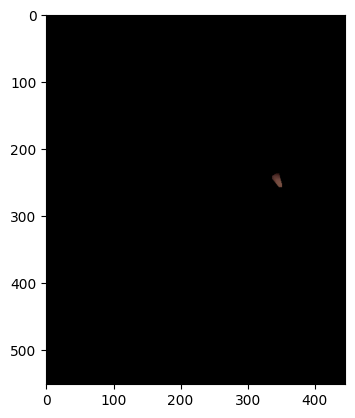

In [50]:
# plt.imshow(s_masked)#added2
# f, axarr = plt.subplots(1, 2)
# axarr[0].imshow(s_masked)
# axarr[1].imshow(mixed_clone)
plt.imshow(cv2.dilate(s_masked, np.ones((5, 5)), iterations=1))

mixed_clone = cv2.seamlessClone(
    added2, 
    t_aligned, 
    added2[:, :, 1], 
    (added2.shape[1] // 2, added2.shape[0] // 2), 
    cv2.MIXED_CLONE
)
plt.imshow(mixed_clone)

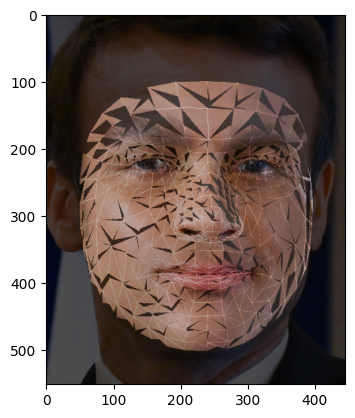

In [62]:
add = cv2.addWeighted(t_aligned, 0.3, added2, 0.5, 0)
plt.imshow(add)

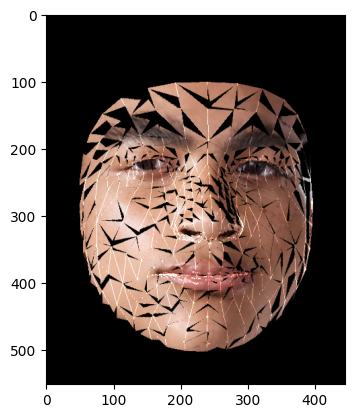

In [52]:
plt.imshow(cv2.morphologyEx(added2, cv2.MORPH_OPEN, (75, 75)))

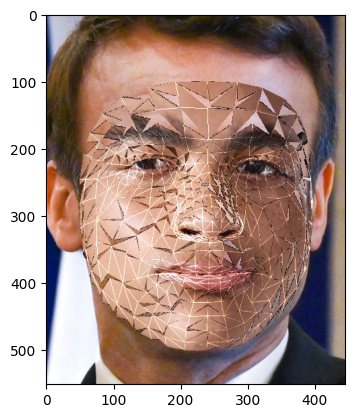

In [53]:
final_mask = (added2.sum(axis = 2) == 0).astype(np.uint8)
orig = cv2.bitwise_and(t_aligned, t_aligned, mask=final_mask)
res = cv2.add(orig, added2)

#b = cv2.bilateralFilter(added2, d=15, sigmaColor=75, sigmaSpace=75)
#plt.imshow(cv2.addWeighted(res, 0.5, b, 0.5, 0))
plt.imshow(res)


In [54]:
mixed_clone = cv2.seamlessClone(
    orig, 
    added2, 
    #np.ones(final_mask.shape, np.uint8) * 255,
    cv2.bitwise_not(final_mask), 
    (added2.shape[1] // 2, added2.shape[0] // 2), 
    cv2.MIXED_CLONE
)

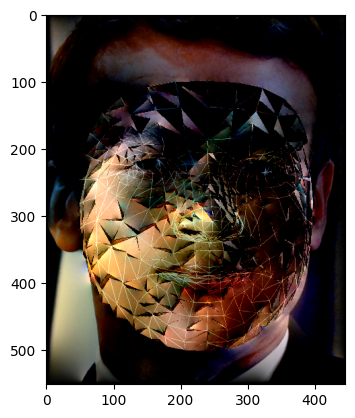

In [55]:
plt.imshow(mixed_clone)

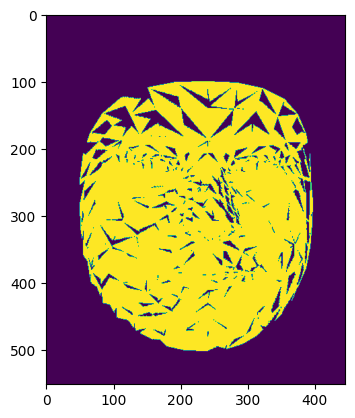

In [56]:
plt.imshow(cv2.bitwise_not(final_mask))

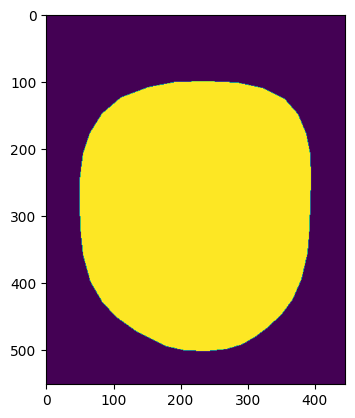

In [57]:
ffm = get_zone_mask(t_aligned, FACE_SHAPE, t_ldmks)
plt.imshow(ffm)

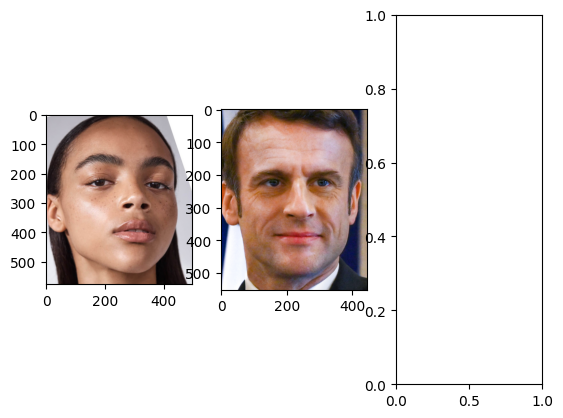

In [58]:
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

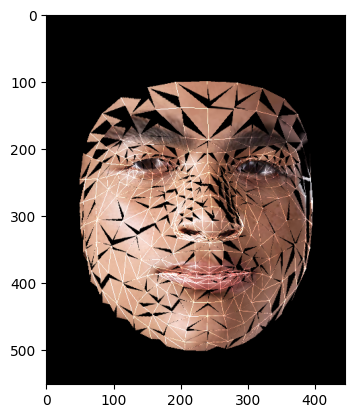

In [59]:
plt.imshow(added2)